<a href="https://colab.research.google.com/github/hafsaAit/forecasting-using-random-forest/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
pip install pandas

In [47]:
pip install scikit-learn

In [48]:
pip install  matplotlib

In [49]:
pip install skforecast

In [50]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import matplotlib.pyplot as plt



In [51]:
df = pd.read_excel("/content/drive/MyDrive/stage/data (journaliers)/RAIB ET LBEN JOURNALIERS.xlsx")


In [52]:
df['Jour Fiscal'] = pd.to_datetime(df['Jour Fiscal'])



df.set_index('Jour Fiscal', inplace=True)



df = df.asfreq('D')


df['Ventes Totales TTC'] = df['Ventes Totales TTC'].replace(0, float('nan'))

df['Ventes Totales TTC'] = df['Ventes Totales TTC'].fillna(method='ffill')


In [53]:
date_fin_train = '2022-10-01'
df_train = df[df.index < date_fin_train]
df_test = df[df.index >= date_fin_train]

In [54]:
df[f'moving_avg_{3}'] = df['Ventes Totales TTC'].rolling(window=3).mean().shift(1)


df[f'moving_avg_{6}'] = df['Ventes Totales TTC'].rolling(window=6).mean().shift(1)


df[f'moving_avg_{12}'] = df['Ventes Totales TTC'].rolling(window=12).mean().shift(1)


In [55]:
# @title Création des lag
df['sale_lastmonth'] = df['Ventes Totales TTC'].shift(1)
df['sale_3Monthsback'] = df['Ventes Totales TTC'].shift(3)
df['sale_6Monthsback'] = df['Ventes Totales TTC'].shift(6)
df['sale_12Monthsback'] = df['Ventes Totales TTC'].shift(12)


In [56]:
df["Date"] = df.index

In [57]:
df["year"] = df["Date"].dt.year
df["quarter"] = df["Date"].dt.quarter
df["month"] = df["Date"].dt.month

df["DAY"] = df["Date"].dt.day


In [58]:

df.drop(columns=['Date'], inplace = True)


In [59]:
df.dropna(inplace=True)


In [60]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=268
)

forecaster.fit(y=df_train['Ventes Totales TTC'])


In [61]:
# Prédictions
steps = len(df_test)
rf_recursive_predictions = forecaster.predict(steps=steps)


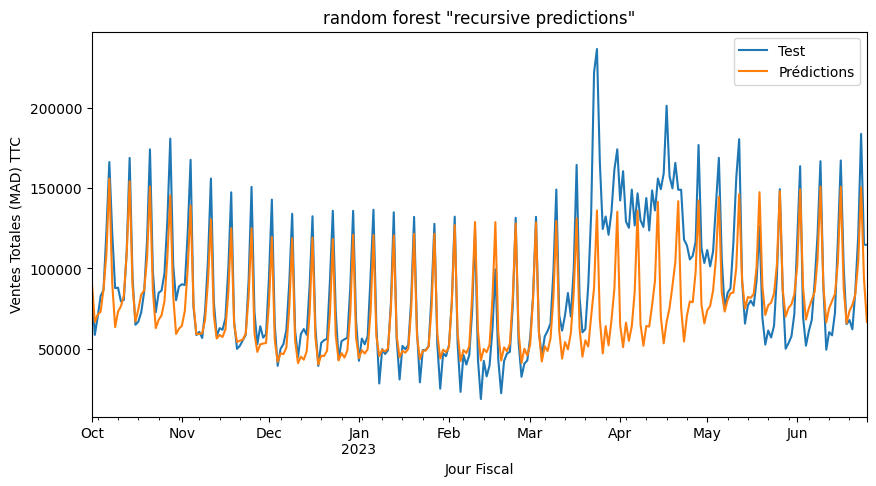

In [62]:
plt.figure(figsize=(10, 5))

df_test['Ventes Totales TTC'].plot(label='Test')
rf_recursive_predictions.plot(label='Prédictions')
plt.xlabel('Jour Fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.title('random forest "recursive predictions"')
plt.legend()
plt.show()


In [63]:
end_date = rf_recursive_predictions.index[-1]

# Générer les dates des trois prochains mois après juin 2023
forecast_start_date = pd.Timestamp('2023-07-01')
forecast_end_date = pd.date_range(start=forecast_start_date, periods=90, freq='D')

# Forecast
steps_forecast = 90
forecast = forecaster.predict(
                        steps=steps_forecast,
                        last_window=df_test.loc[:'2023-07-01',"Ventes Totales TTC"])

# Créer un index pour les prévisions
forecast_index = pd.date_range(start=end_date + pd.Timedelta(days=1), periods=steps_forecast, freq='D')

# Créer une série pandas pour les prévisions avec l'index approprié
forecast_series = pd.Series(forecast, index=forecast_index)


In [64]:
# Forecast
steps_forecast = 90
forecast = forecaster.predict(
                        steps=steps_forecast,
                        last_window=df_test.loc[:'2023-07-01',"Ventes Totales TTC"])

forecast

2023-06-26     92121.20
2023-06-27     92393.31
2023-06-28    112441.47
2023-06-29    133440.55
2023-06-30    178551.06
                ...    
2023-09-19    184084.73
2023-09-20    192728.35
2023-09-21    190958.34
2023-09-22    198498.84
2023-09-23    167824.48
Freq: D, Name: pred, Length: 90, dtype: float64

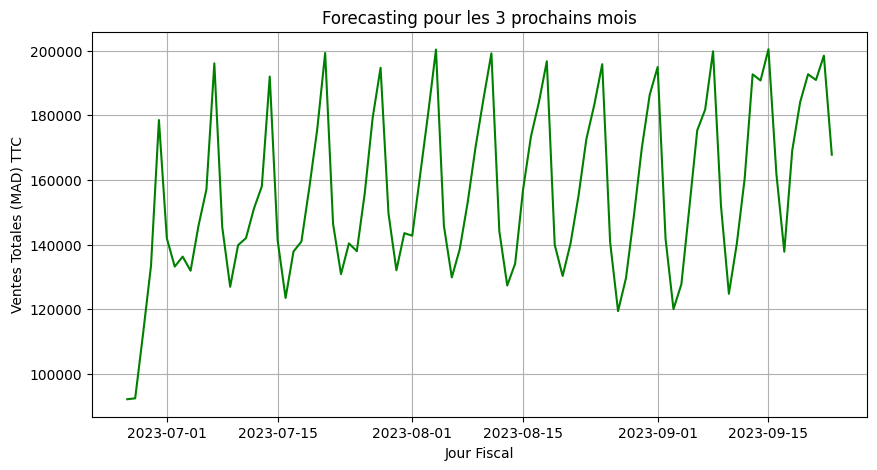

In [65]:

plt.figure(figsize=(10, 5))
plt.plot(forecast_series.index, forecast_series.values, color='green')

plt.xlabel('Jour Fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.title('Forecasting pour les 3 prochains mois')
plt.grid(True)
plt.show()


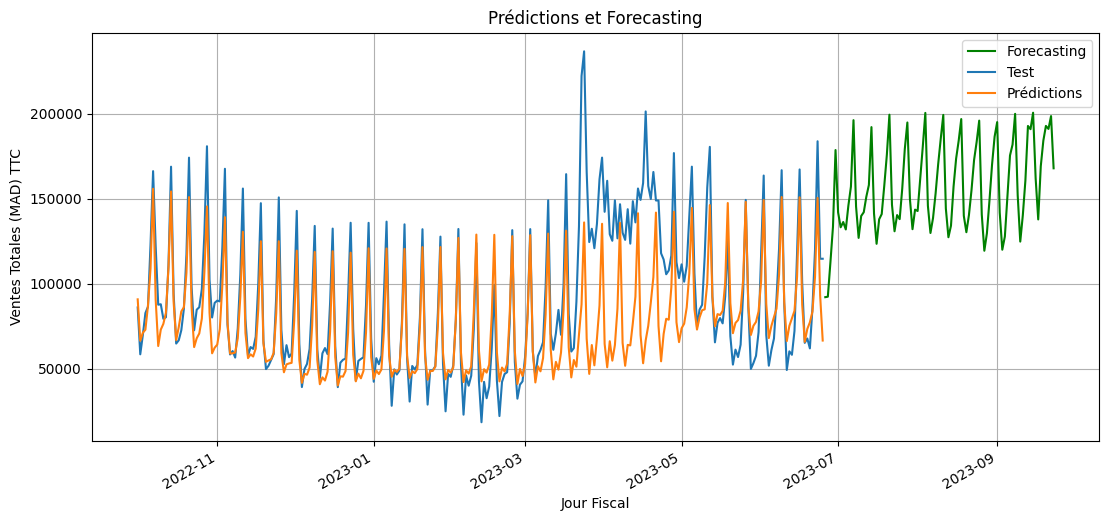

In [66]:

plt.figure(figsize=(13, 6))

# Tracer le forecasting pour les 3 prochains mois
plt.plot(forecast_series.index, forecast_series.values, color='green', label='Forecasting')

# Tracer les données de test et les prédictions
df_test['Ventes Totales TTC'].plot(label='Test')
rf_recursive_predictions.plot(label='Prédictions')

#graphe
plt.xlabel('Jour Fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.title('Prédictions et Forecasting')
plt.grid(True)
plt.legend()

plt.show()


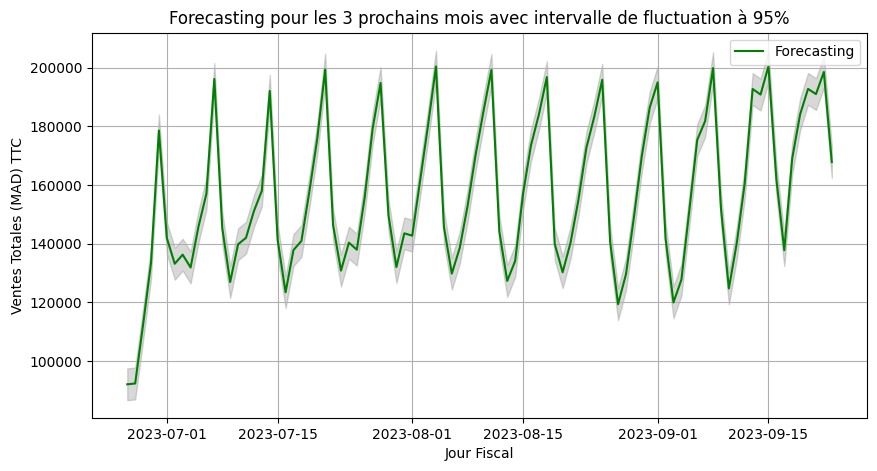

In [67]:
import numpy as np


# Calculer les intervalles de fluctuation
n = len(forecast_series)
t_value = 1.96
std_error = np.std(forecast_series) / np.sqrt(n)
margin_of_error = t_value * std_error

forecast_lower = forecast_series - margin_of_error
forecast_upper = forecast_series + margin_of_error


plt.figure(figsize=(10, 5))
plt.plot(forecast_series.index, forecast_series.values, color='green', label='Forecasting')
plt.fill_between(forecast_series.index, forecast_lower.values, forecast_upper.values, color='grey', alpha=0.3)

plt.xlabel('Jour Fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.title('Forecasting pour les 3 prochains mois avec intervalle de fluctuation à 95%')
plt.grid(True)
plt.legend()


plt.show()


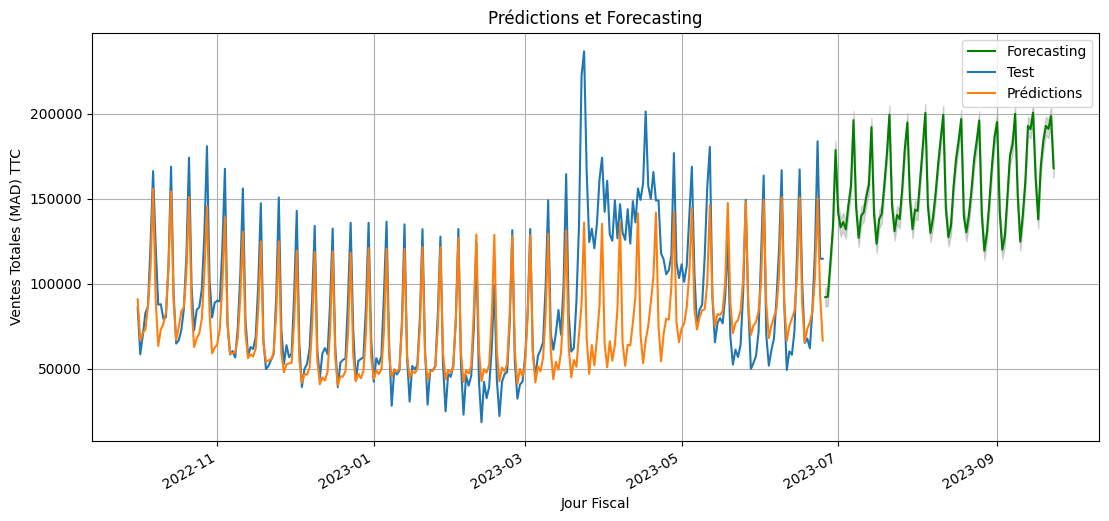

In [68]:

plt.figure(figsize=(13, 6))

# Tracer le forecasting pour les 3 prochains mois
plt.plot(forecast_series.index, forecast_series.values, color='green', label='Forecasting')
plt.fill_between(forecast_series.index, forecast_lower.values, forecast_upper.values, color='grey', alpha=0.3)

# Tracer les données de test et les prédictions
df_test['Ventes Totales TTC'].plot(label='Test')
rf_recursive_predictions.plot(label='Prédictions')

#graphe
plt.xlabel('Jour Fiscal')
plt.ylabel('Ventes Totales (MAD) TTC')
plt.title('Prédictions et Forecasting')
plt.grid(True)
plt.legend()

plt.show()
